<a href="https://colab.research.google.com/github/JiweiHou/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y0pfw0ww
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-y0pfw0ww
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=eaab46a48d2b8c5746b8d77dda997eb4b7174752bed2e899d4ab868751f7c1ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-c5l8sr9n/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-11-11 13:57:44--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [8]:
image = cv2.imread('sample_data/rgb.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

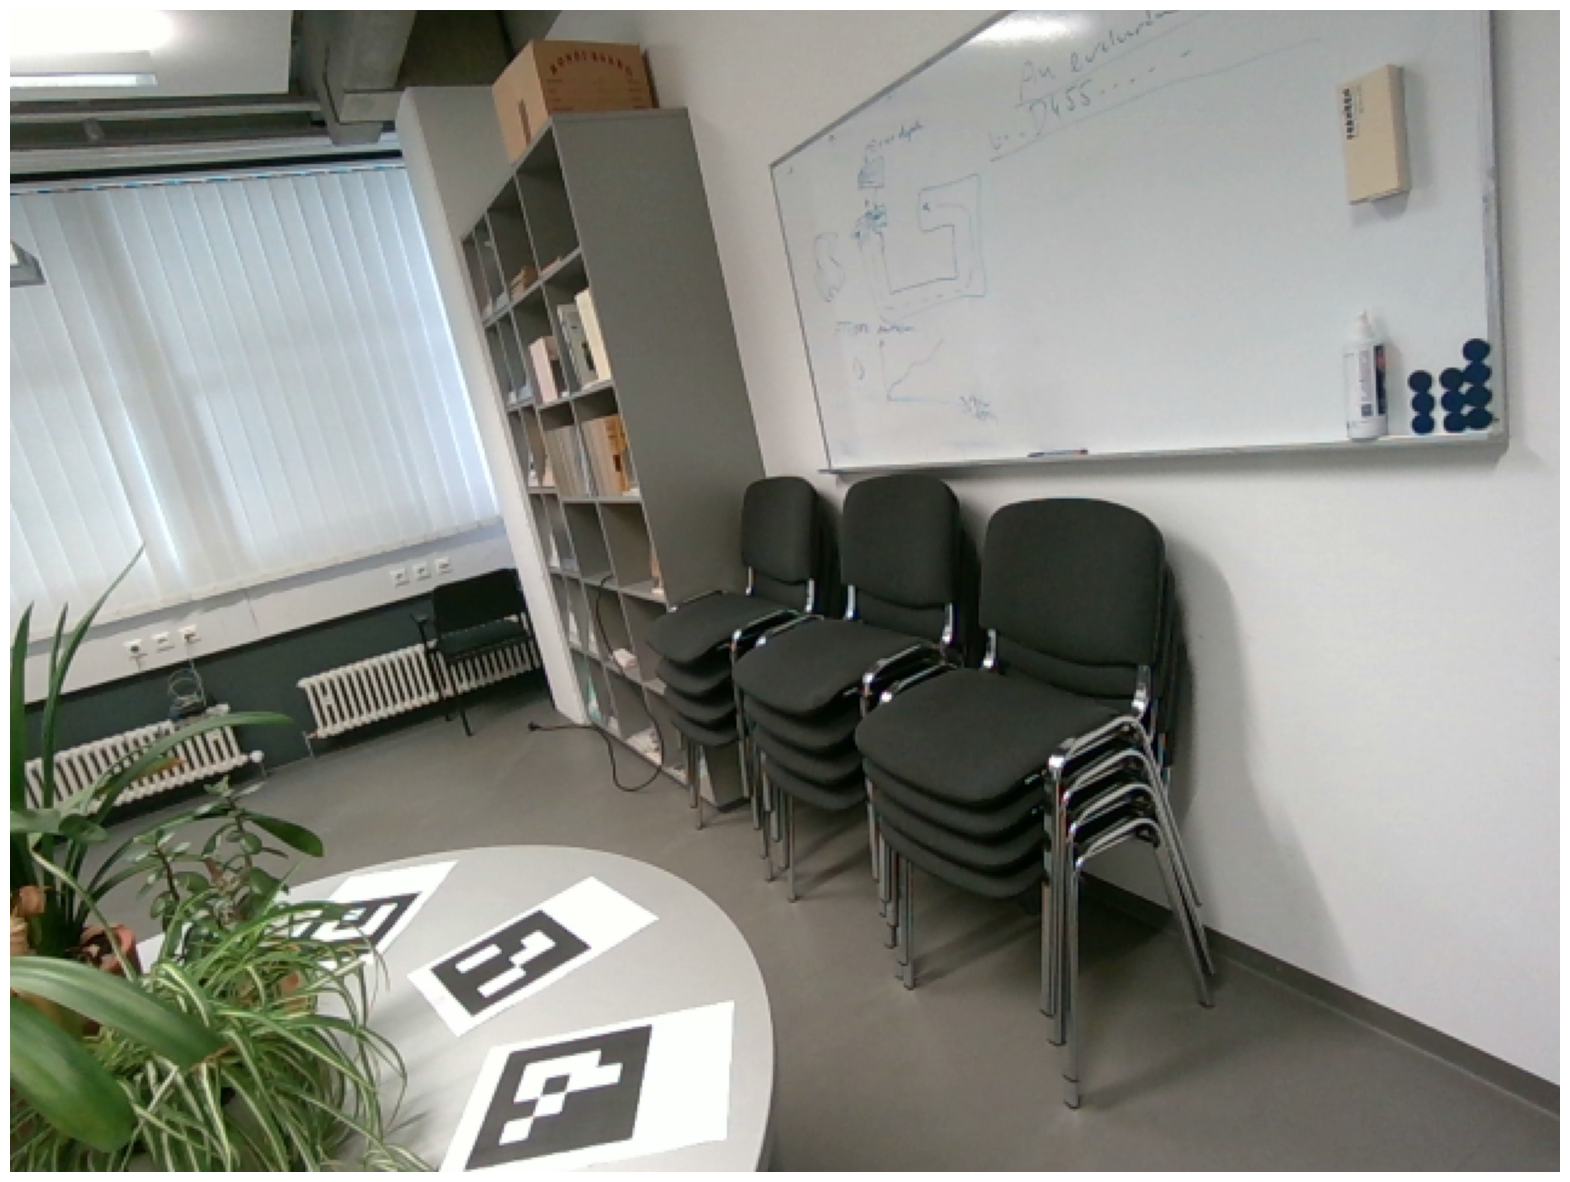

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [10]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


To generate masks, just run `generate` on an image.

In [11]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [12]:
print(len(masks))
print(masks[0].keys())

101
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

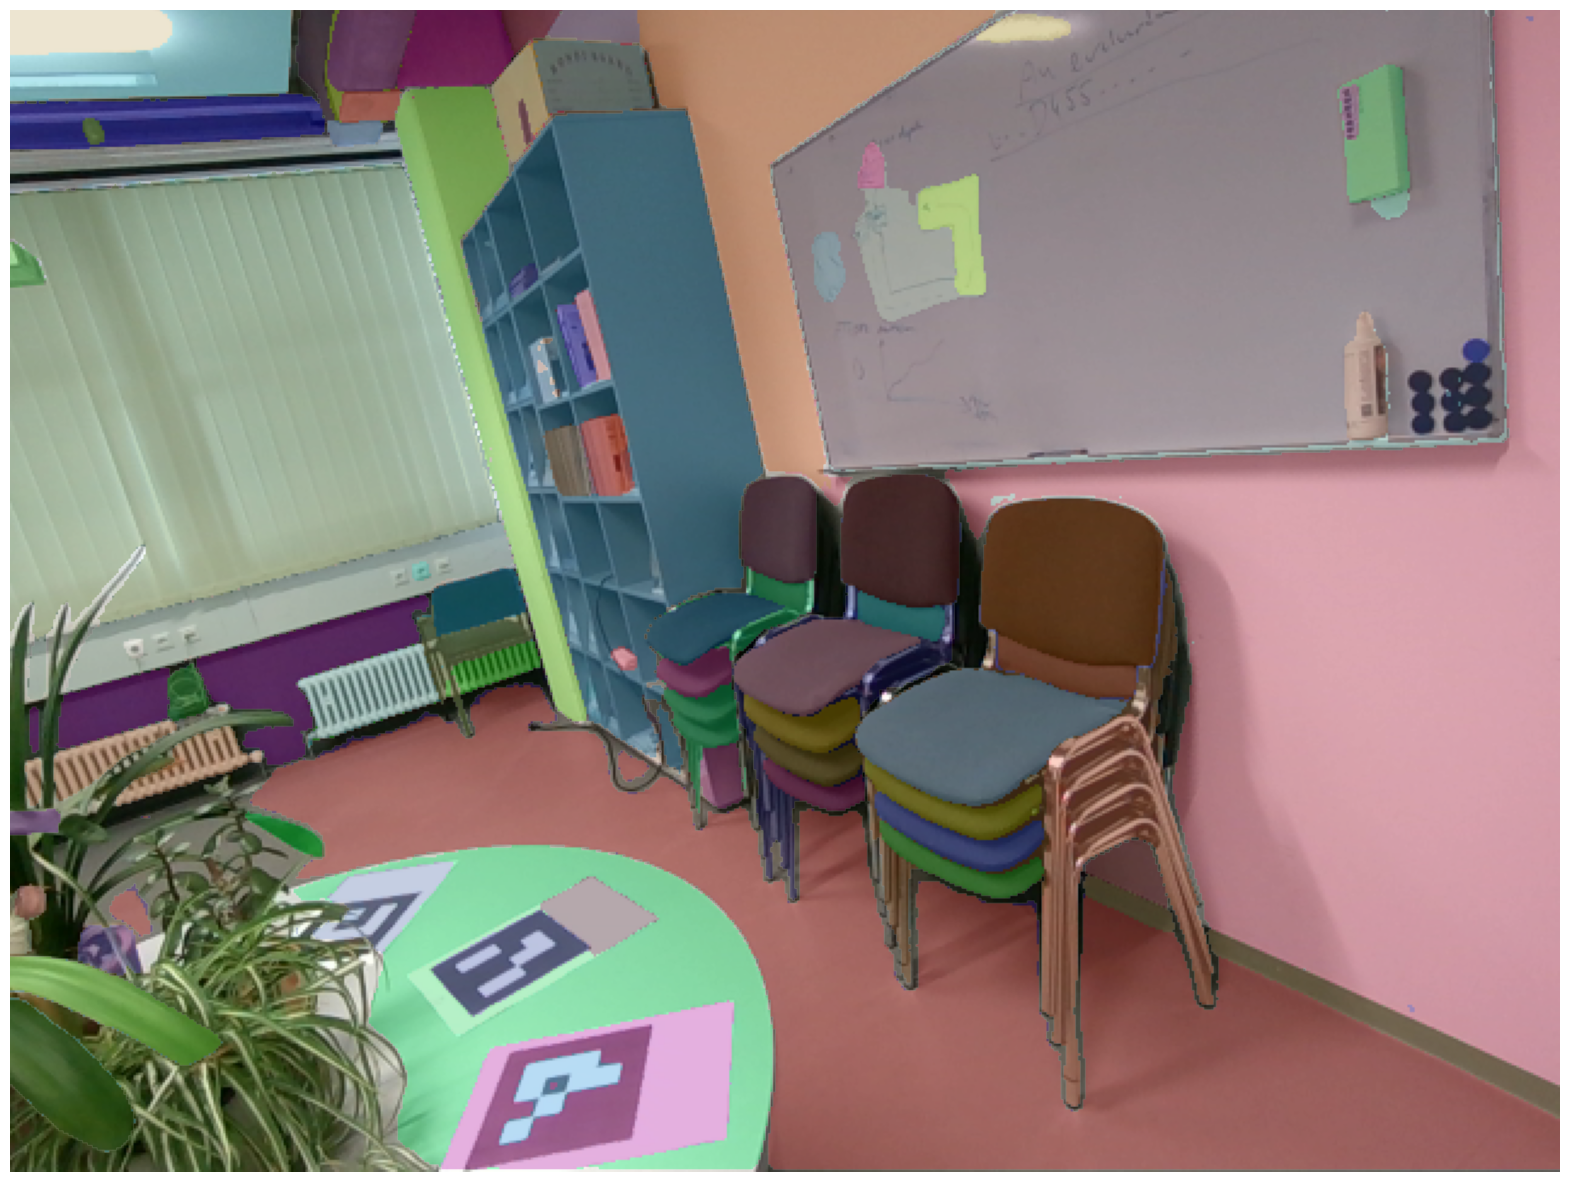

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [16]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


Mask 0 - points_3d shape: (27589, 3), colors shape: (27589, 3)
Mask 1 - points_3d shape: (1894, 3), colors shape: (1894, 3)
Mask 2 - points_3d shape: (49342, 3), colors shape: (49342, 3)
Mask 3 - points_3d shape: (51826, 3), colors shape: (51826, 3)
Mask 4 - points_3d shape: (5965, 3), colors shape: (5965, 3)
Mask 5 - points_3d shape: (18529, 3), colors shape: (18529, 3)
Mask 6 - points_3d shape: (37430, 3), colors shape: (37430, 3)
Mask 7 - points_3d shape: (264, 3), colors shape: (264, 3)
Mask 8 - points_3d shape: (2397, 3), colors shape: (2397, 3)
Mask 9 - points_3d shape: (1336, 3), colors shape: (1336, 3)
Mask 10 - points_3d shape: (2737, 3), colors shape: (2737, 3)
Mask 11 - points_3d shape: (614, 3), colors shape: (614, 3)
Skipping empty mask 12
Mask 13 - points_3d shape: (1284, 3), colors shape: (1284, 3)
Mask 14 - points_3d shape: (5978, 3), colors shape: (5978, 3)
Mask 15 - points_3d shape: (4765, 3), colors shape: (4765, 3)
Mask 16 - points_3d shape: (2719, 3), colors shape:

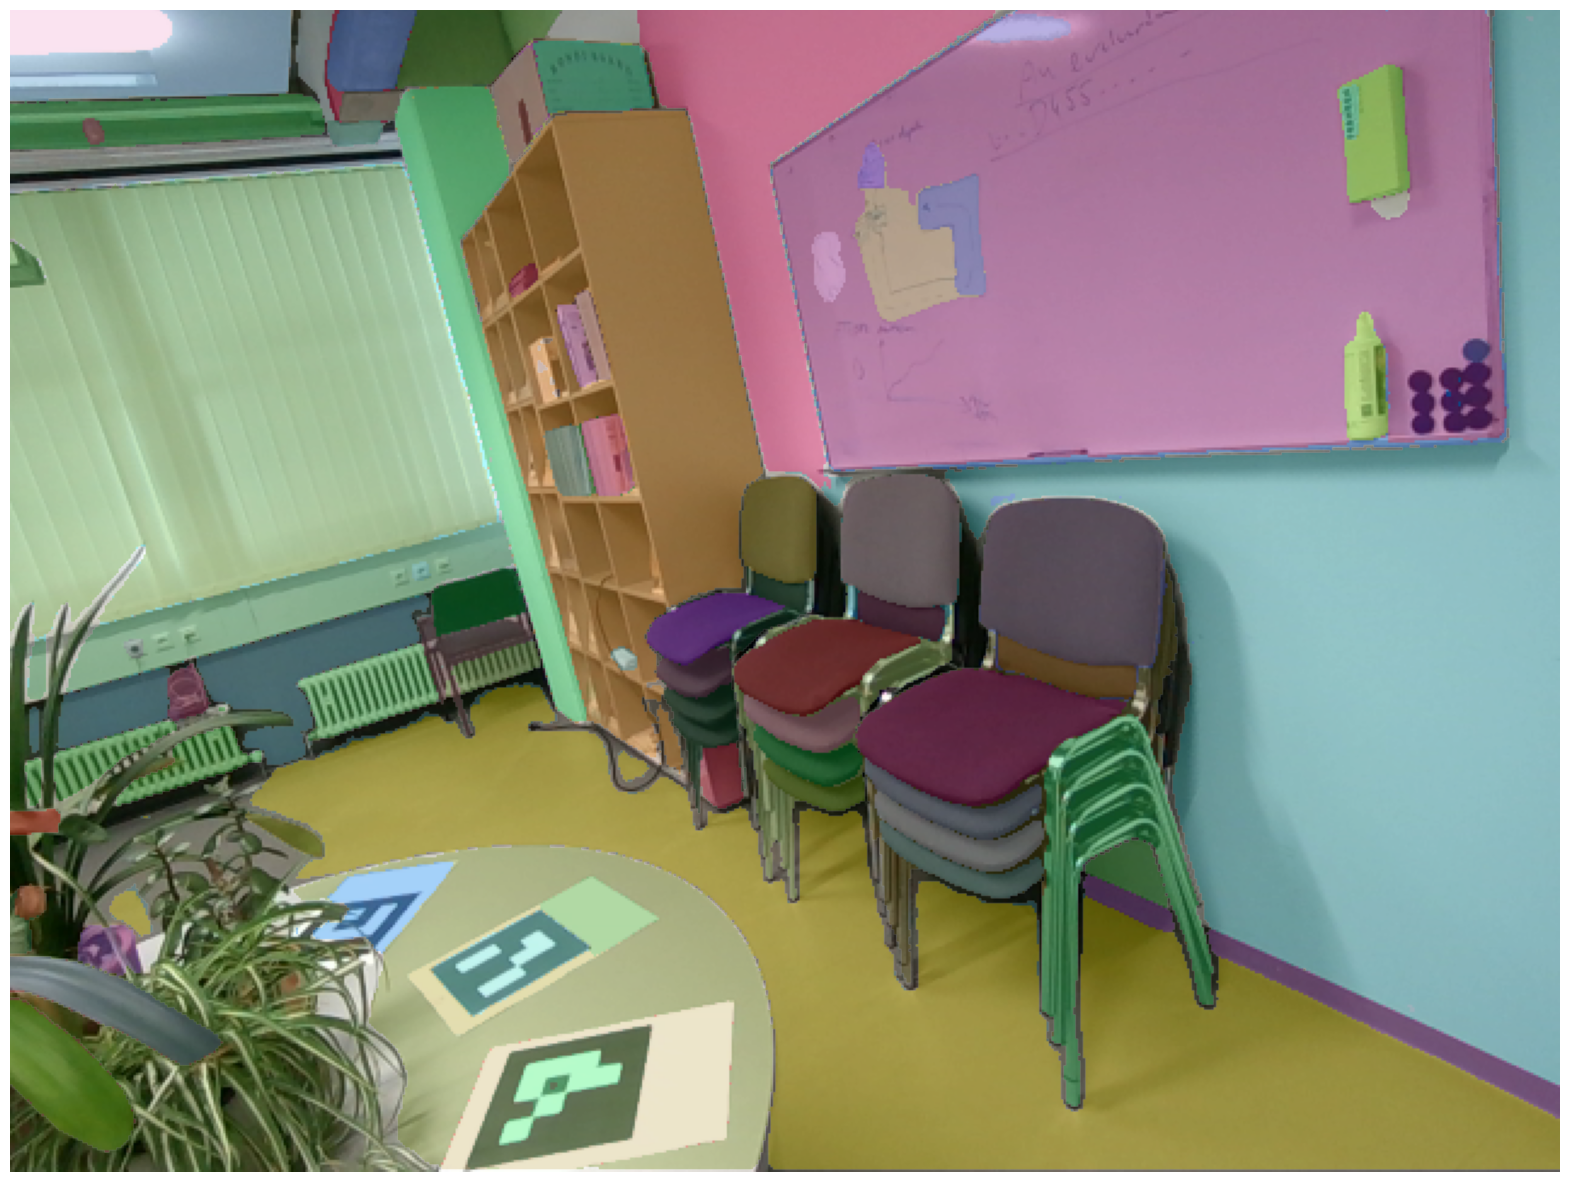

3D point cloud for all masks saved as all_masks_point_cloud.ply.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

# 假设相机内参
fx, fy = 381.15676, 380.74679  # 焦距 (示例值，请替换为实际值)
cx, cy = 316.73738, 241.33566  # 主点 (示例值，请替换为实际值)

# 加载RGB和深度图
rgb_image = cv2.imread('sample_data/rgb.png')
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)  # 转换为 RGB 格式
depth_image = cv2.imread('sample_data/depth.png', cv2.IMREAD_UNCHANGED)
depth_image = depth_image.astype(np.float32) / 1000.0  # 假设深度值以毫米为单位，转换为米

# 用于显示和生成掩码
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# 生成3D点云的函数
def mask_to_point_cloud(mask, depth, rgb, fx, fy, cx, cy):
    points = []
    colors = []
    h, w = mask.shape
    for v in range(h):
        for u in range(w):
            if mask[v, u]:  # 如果在掩码中
                z = depth[v, u]
                if z > 0:  # 深度值有效
                    x = (u - cx) * z / fx
                    y = (v - cy) * z / fy
                    points.append((x, y, z))
                    colors.append(rgb[v, u] / 255.0)  # 归一化 RGB 值到 [0, 1]
    return np.array(points), np.array(colors)

# 加载预训练的SAM模型
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# 使用 SAM 生成所有掩码
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(rgb_image)

# 处理并保存每个掩码的3D点云
pcd_all = o3d.geometry.PointCloud()  # 用于存储所有点云

for i, mask_data in enumerate(masks):
    mask = mask_data['segmentation']  # 获取掩码
    points_3d, colors = mask_to_point_cloud(mask, depth_image, rgb_image, fx, fy, cx, cy)

    # 跳过空点云
    if points_3d.size == 0:
        print(f"Skipping empty mask {i}")
        continue

    # 检查 points_3d 和 colors 的形状
    print(f"Mask {i} - points_3d shape: {points_3d.shape}, colors shape: {colors.shape}")

    # 将单个掩码的点云添加到整体点云中
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd_all += pcd


# 可视化掩码
plt.figure(figsize=(20, 20))
plt.imshow(rgb_image)
show_anns(masks)
plt.axis('off')
plt.show()

# 保存整体点云到 .ply 文件
o3d.io.write_point_cloud("all_masks_point_cloud.ply", pcd_all)
print("3D point cloud for all masks saved as all_masks_point_cloud.ply.")


## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

90

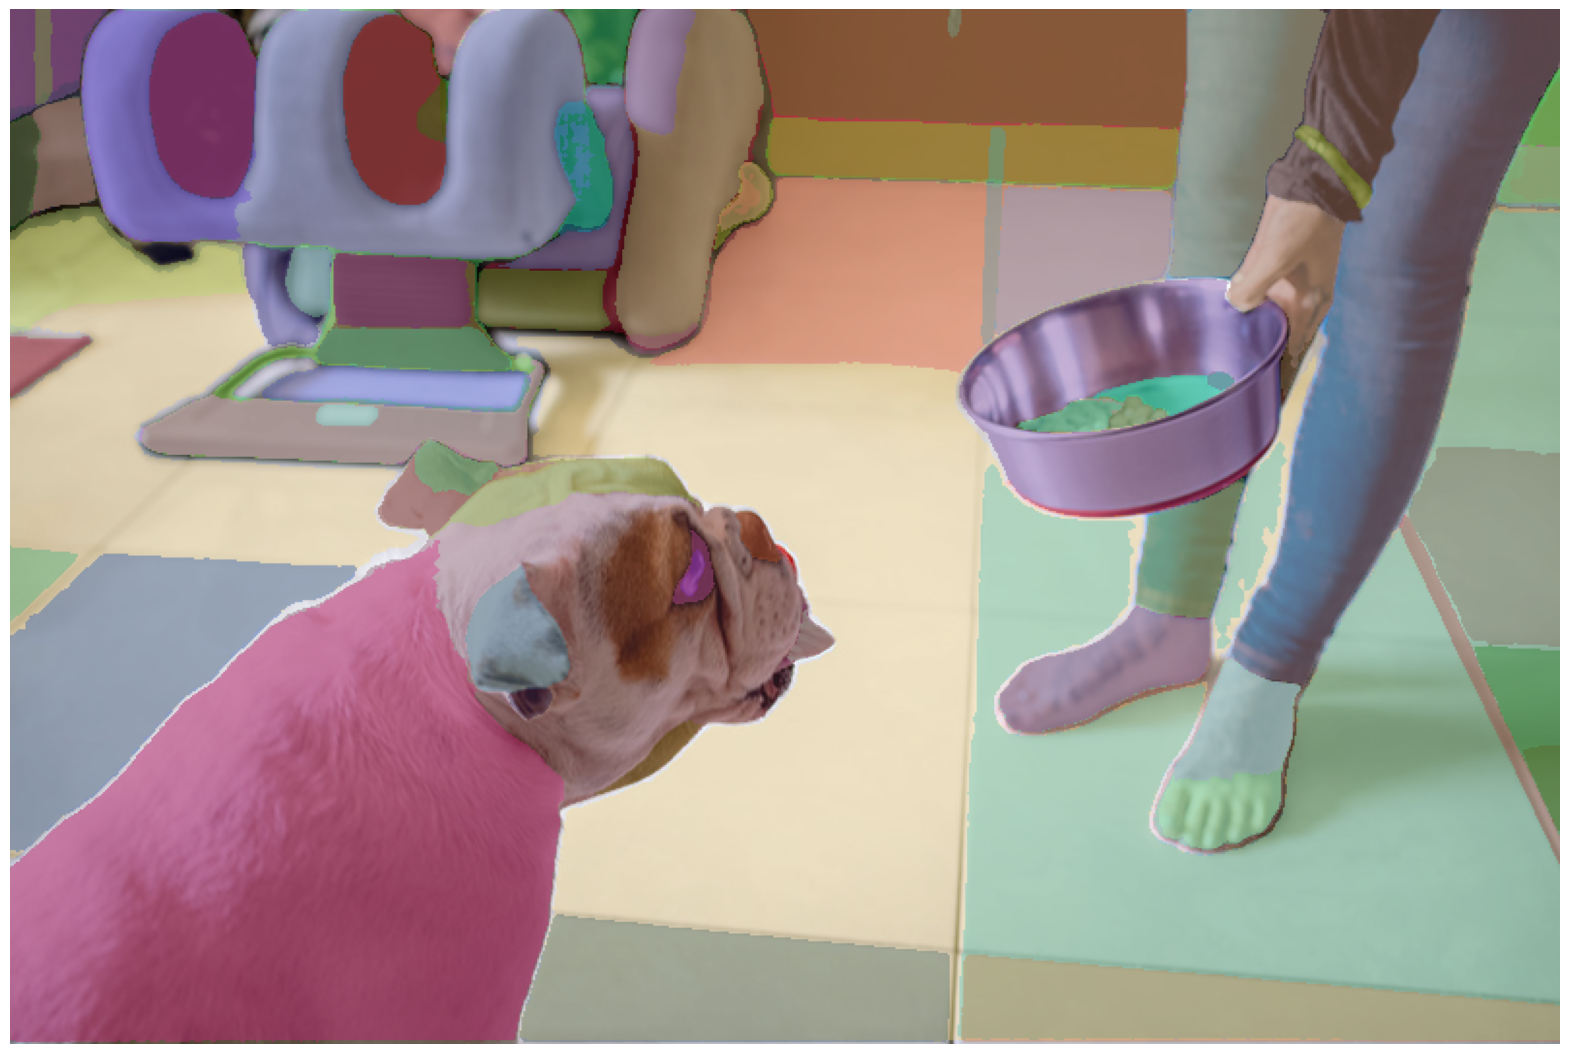

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()